# Scotch Whiskey analysis <a id='top'></a>

<ul>
<li>[Data preprocessing](#data_prep)
<li>[Explanatory data analysis](#EDA)
<li>[Assumptions and approach](#assumptions)
<li>[Clustering](#clustering)
<li>[Feature importances](#feat_imp)
<li>[Conclusions](#conclusions)
</ul>

# Data preprocessing 
<a id='data_prep'></a>

### Imports

In [791]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from IPython.display import display

### Helper functions

In [792]:
def load_dataset():
    """
    Function return the dataframe with the loaded data
    """
    filename = 'scotch.xlsx'
    filepath = 'Scotch data (Windows)\\'
    path = os.path.normpath(filepath + filename)
    df = pd.read_excel(path, header=None)  # skipping headers until better understanding of the dataset
    return df


def load_txt(txt_filename):
    """
    Function loads the txt file and return a dataframe with the data
    """
    filepath = 'Scotch data (Windows)\\'
    path = os.path.normpath(filepath + txt_filename)
    f = open(path, mode='rt', newline='\n')
    f.close()
    df = pd.read_csv(path, sep='')
    return df



def plot_bar_cat(columns, data, title):
    """
    Function plots cumulative sum of the values in a bar plot
    """
    sequence = df[columns].sum().sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    plt.title(f'Whiskey '+ title, fontsize=16)
    sns.barplot(x=sequence.index, y=sequence)
    plt.xticks(rotation=45, fontsize=14)
    plt.show()
    pass


def plot_bar_num(columns, data, title):
    """
    Function plots counts of particular values in a bar plot
    """
    to_plot = data[columns].value_counts().sort_values(ascending=True)
    plt.figure(figsize=(15,5))
    plt.title(f'Whiskey ' + title, fontsize=16)
    sns.barplot(x=to_plot.index, y = to_plot)
    plt.ylabel('Count', fontsize=14)
    plt.show()
    pass

### Data structure

<ul>
<li> There are loose 'txt' files that contain different categorical variables in a columns
<li> There is 'txt' file having location cooridinates of the distillery 
<li> 'txt' file with (109 x 109) array with distances between one distileery to the others
<li> 'xlxs' file with all the variables aggregates but also containg other features not present elsewhere:
<ul> 
<li> score
<li> dist
<li> age
<li> %
</ul>
<ul> 

At this stage I am going to use aggregated excel file and perform cleaning and feature engineering.

In [793]:
os.listdir('Scotch data (Windows)\\')

['BODY.TXT',
 'COLOR.TXT',
 'DIST-GEO.TXT',
 'DISTCOOR.TXT',
 'FINISH.TXT',
 'NOSE.TXT',
 'PALATE.TXT',
 'readme.txt',
 'REGIONS.TXT',
 'SCOTCH.TXT',
 'scotch.xlsx',
 '~$scotch.xlsx']

Loading the dataset and displaying the first and last rows

In [794]:
df = load_dataset()
display(df.head())
display(df.iloc[-5:,:])

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,NaN,NaN,color,color,color,color,color,color,color,color,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NAME,NaN,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
2,Aberfeldy,Aberfeldy,0,1,0,0,0,0,0,0,...,MIDLAND,0,1,0,0,0,0,0,0,0
3,Aberlour,Aberlour,0,0,0,0,0,0,0,0,...,SPEY,0,0,1,0,0,0,0,0,0
4,Ardberg,Ardberg,0,0,0,0,0,0,0,0,...,SOUTH,1,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
108,Tomintoul,Tomintoul,0,0,0,0,0,0,0,1,...,SPEY,0,0,1,0,0,0,0,0,0
109,Tormore,Tormore,0,0,0,0,0,0,0,1,...,SPEY,0,0,1,0,0,0,0,0,0
110,Tullibardine,Tullibardi,0,0,0,0,0,1,0,0,...,MIDLAND,0,1,0,0,0,0,0,0,0
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,8,2,2,4,10,21,2,27,...,NaN,7,6,57,10,5,7,9,3,5


Some rows contain NaN values and redundant information.

### Data cleaning

Assinging columns names and dropping rows 

In [795]:
df.columns = list(df.iloc[1,:])  # takes the names of columns in the 2nd row
df.columns = [str(x).lower() for x in df.columns]  # change the names to string to deal with nan value

df = df.iloc[2:111,:]  # dropping rows containing nan and insignificant information
df.drop(labels=df.columns[1], axis=1, inplace=True)  # dropping columns that is a duplicate of the first
df.reset_index(inplace=True)  # resetting rows index
df.drop(labels=['index'], axis=1, inplace=True)

Changing the names of the columns. Additionaly splitting into the main categories.

In [796]:
columns = df.columns
print(columns)

new_cols = []

color_columns = []
nose_columns = []
body_columns = []
pale_columns = []
finish_columns = []

for i, col in enumerate(columns):
    if (i>=1) & (i<=14):
        n_col = col + '_color'
        color_columns.append(n_col)
    elif (i>14) & (i<=27):
        n_col = col + '_nose'
        nose_columns.append(n_col)       
    elif (i>27) & (i<=34):
        n_col = col + '_body'
        body_columns.append(n_col) 
    elif (i>34) & (i<=49):
        n_col = col + '_pale'
        pale_columns.append(n_col) 
    elif (i>49) & (i<=68):
        n_col = col + '_finish'
        finish_columns.append(n_col)        
    else:
        n_col = col
        
    new_cols.append(n_col)

df.columns = new_cols

Index(['name', 'wyne', 'yellow', 'v.pale', 'pale', 'p.gold', 'gold', 'o.gold',
       'f.gold', 'bronze', 'p.amber', 'amber', 'f.amber', 'red', 'sherry',
       'aroma', 'peat', 'sweet', 'light', 'fresh', 'dry', 'fruit', 'grass',
       'sea', 'sherry', 'spicy', 'rich', 'soft', 'med', 'full', 'round',
       'smooth', 'light', 'firm', 'oily', 'full', 'dry', 'sherry', 'big',
       'light', 'smooth', 'clean', 'fruit', 'grass', 'smoke', 'sweet', 'spice',
       'oil', 'salt', 'arome', 'full', 'dry', 'warm', 'big', 'light', 'smooth',
       'clean', 'fruit', 'grass', 'smoke', 'sweet', 'spice', 'oil', 'salt',
       'arome', 'ling', 'long', 'very', 'quick', 'age', 'dist', 'score', '%',
       'region', 'district', 'islay', 'midland', 'spey', 'east', 'west',
       'north ', 'lowland', 'campbell', 'islands'],
      dtype='object')


Checking the categorical variables

In [797]:
df[body_columns].head()

,med_body,full_body,round_body,smooth_body,light_body,firm_body,oily_body
0,1,0,0,0,0,0,0
1,1,1,1,1,0,0,0
2,1,1,0,0,1,1,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0


In [798]:
df[nose_columns].head()

,aroma_nose,peat_nose,sweet_nose,light_nose,fresh_nose,dry_nose,fruit_nose,grass_nose,sea_nose,sherry_nose,spicy_nose,rich_nose,soft_nose
0,1,1,0,0,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,1,1
2,0,1,0,0,0,1,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,1,0,1,1,0,0,0,0,1


It appears that the categories are not one hot encoded. A whiskey can have 1 in multiple columns within one category.

### Additional features cleaning

Detected that numerical column age has negative values which might be an error. I am assuming that -9 is representing 9.

In [799]:
new_values = []
for row in df.iterrows():
    if row[1]['age'] == -9:
        new_values.append(9)
    else:
        new_values.append(row[1]['age'])
        
df['age']=new_values

Detected whitespaces as part of names which will cause inproper encoding later on. 

In [800]:
df['region']=[s.strip() for s in df['region']]
df['district']=[s.strip() for s in df['district']]

Removing columns that do not hold numerical data in preparation of cleaning the values. 

In [801]:
cols_to_change = new_cols
cols_to_change.remove('region')
cols_to_change.remove('district')
cols_to_change.remove('name')

Changing from object type to int for the remaining columns

In [543]:
for col in cols_to_change:
    df[col] = [int(x) for x in df[col]]

Checking if the types are int now:


In [544]:
df[cols_to_change].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 81 columns):
wyne_color       109 non-null int64
yellow_color     109 non-null int64
v.pale_color     109 non-null int64
pale_color       109 non-null int64
p.gold_color     109 non-null int64
gold_color       109 non-null int64
o.gold_color     109 non-null int64
f.gold_color     109 non-null int64
bronze_color     109 non-null int64
p.amber_color    109 non-null int64
amber_color      109 non-null int64
f.amber_color    109 non-null int64
red_color        109 non-null int64
sherry_color     109 non-null int64
aroma_nose       109 non-null int64
peat_nose        109 non-null int64
sweet_nose       109 non-null int64
light_nose       109 non-null int64
fresh_nose       109 non-null int64
dry_nose         109 non-null int64
fruit_nose       109 non-null int64
grass_nose       109 non-null int64
sea_nose         109 non-null int64
sherry_nose      109 non-null int64
spicy_nose       109 non-null i

# EDA <a id='EDA'></a>
[top](#top)

I am going throught the features in the dataset to obtain some insight into the whiskey data gathered.

### Whiskey score

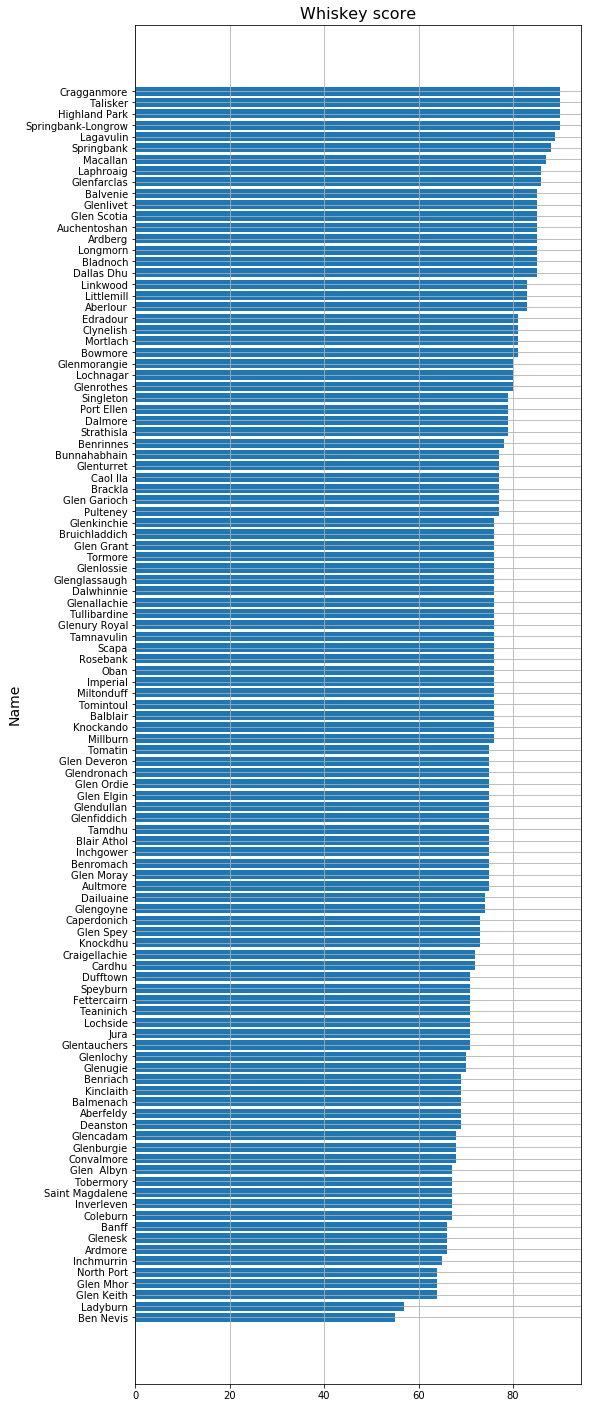

In [545]:
df.sort_values(by='score', axis=0, ascending=True, inplace=True)

plt.figure(figsize=(8,25))
plt.title('Whiskey score',fontsize=16)
plt.ylabel('Name', fontsize=14)
plt.grid()
plt.barh(width=df.score, y=df.name)
plt.show()

### Whiskey features

In [802]:
titles_cat = ['Color', 'Nose', 'Body', 'Palate', 'Finish']
col_list_cat = [color_columns, nose_columns, body_columns, pale_columns, finish_columns]

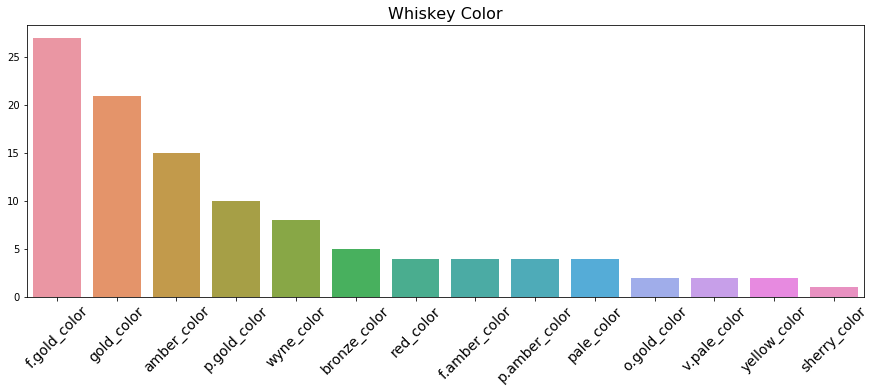

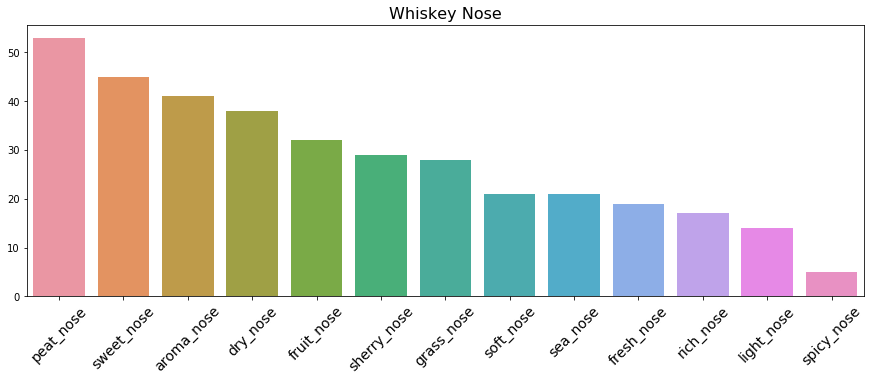

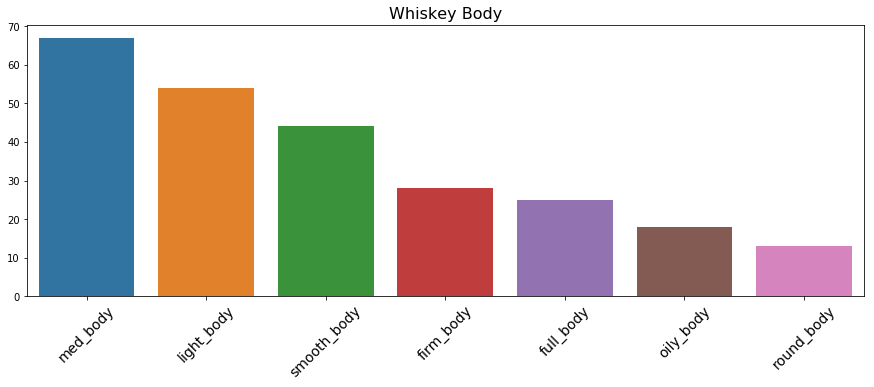

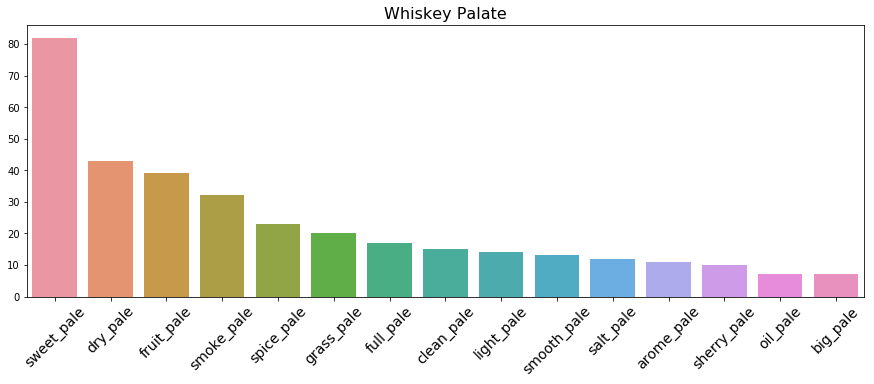

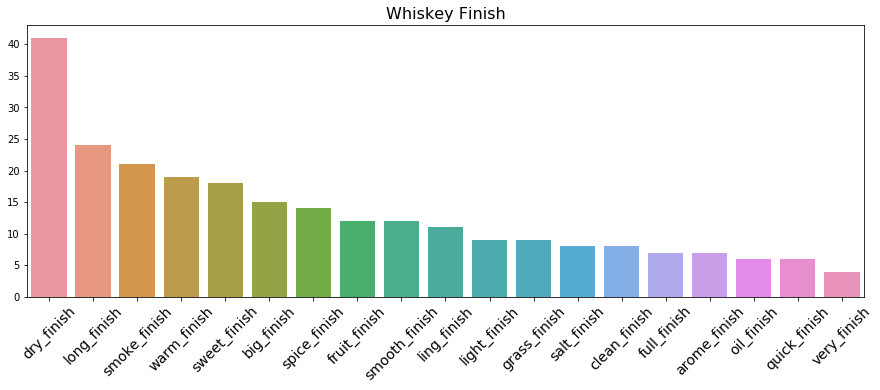

In [803]:
for i, item in enumerate(titles_cat):
    plot_bar_cat(col_list_cat[i], df, item)

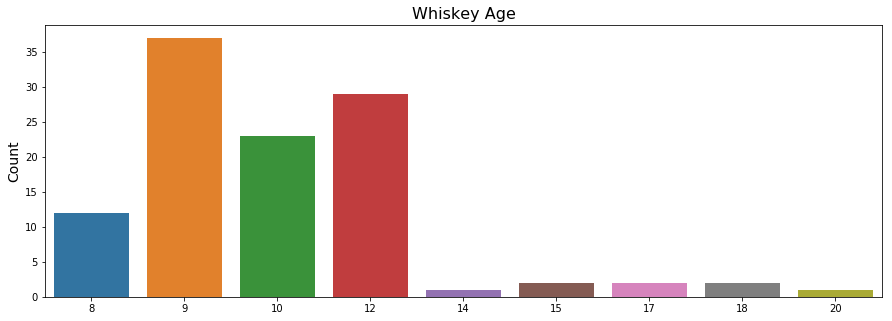

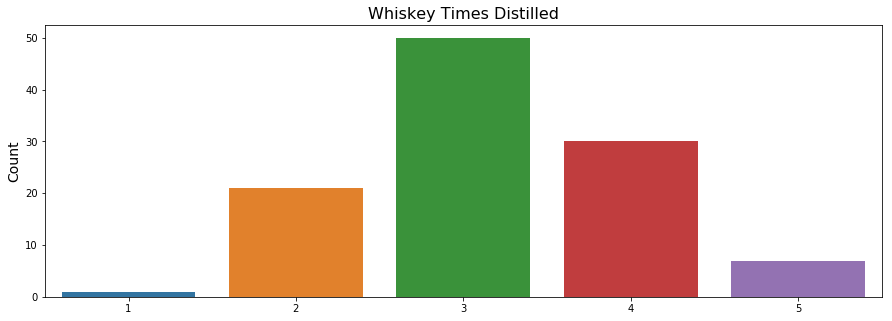

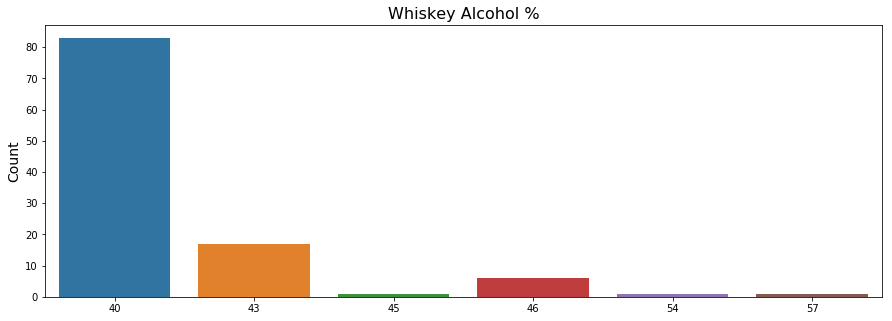

In [548]:
titles = ['Age', 'Times Distilled', 'Alcohol %']
cols = ['age', 'dist', '%']

for i, item in enumerate(titles):
    plot_bar_num(cols[i], df, item)

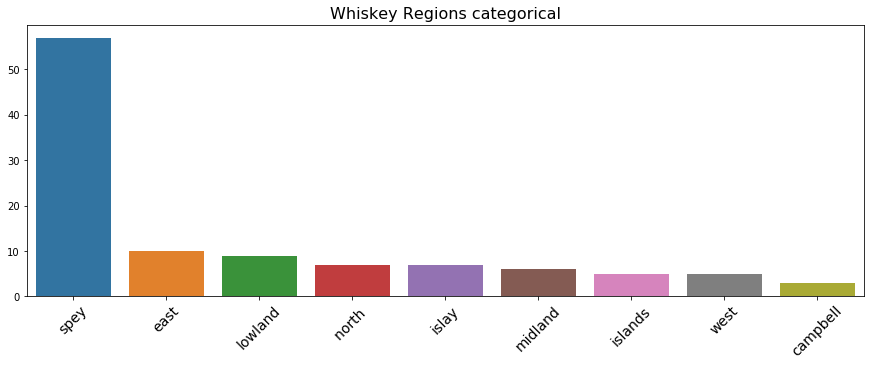

In [549]:
regions_cat = ['islay', 'midland', 'spey',
       'east', 'west', 'north ', 'lowland', 'campbell', 'islands']

plot_bar_cat(regions_cat, df, 'Regions categorical')

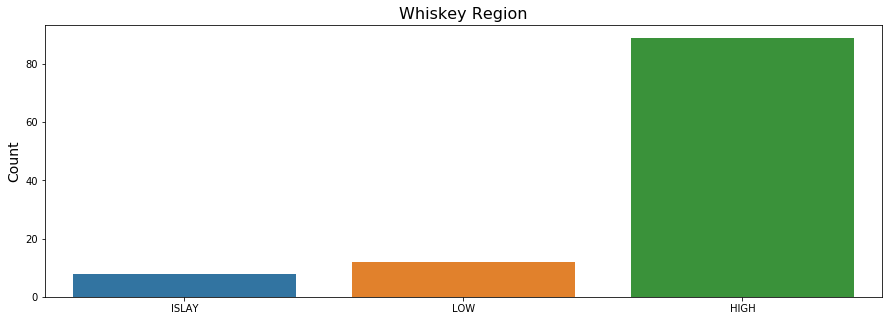

In [550]:
plot_bar_num('region', df, 'Region')

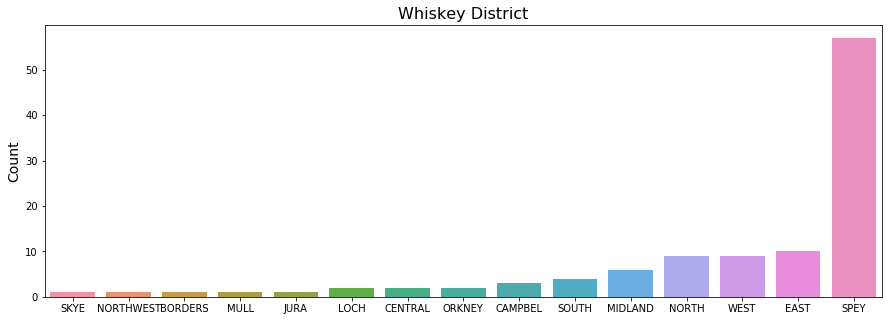

In [551]:
plot_bar_num('district', df, 'District')

### Checks in preparation of the summary

In [552]:
df[['age','%','score','dist']].describe()

,age,%,score,dist
count,109.000000,109.000000,109.000000,109.000000
mean,10.467890,41.128440,75.587156,3.192661
std,2.295603,2.617961,6.947170,0.855019
min,8.000000,40.000000,55.000000,1.000000
25%,9.000000,40.000000,71.000000,3.000000
50%,10.000000,40.000000,76.000000,3.000000
75%,12.000000,40.000000,79.000000,4.000000
max,20.000000,57.000000,90.000000,5.000000


In [553]:
len(df['district'].unique())

15

In [554]:
len(df.loc[df['district']=='SPEY'])/109*100

52.293577981651374

In [555]:
len(df.loc[df['region']=='HIGH'])/109*100

81.65137614678899

In [556]:
regions_cat = ['islay', 'midland', 'spey',
       'east', 'west', 'north ', 'lowland', 'campbell', 'islands']

In [557]:
df['spey'].sum()/109*100

52.293577981651374

In [558]:
df[regions_cat].sum()

islay        7
midland      6
spey        57
east        10
west         5
north        7
lowland      9
campbell     3
islands      5
dtype: int64

In [559]:
df.district.value_counts()

SPEY         57
EAST         10
NORTH         9
WEST          9
MIDLAND       6
SOUTH         4
CAMPBEL       3
LOCH          2
CENTRAL       2
ORKNEY        2
SKYE          1
NORTHWEST     1
BORDERS       1
MULL          1
JURA          1
Name: district, dtype: int64

In [560]:
df.age.value_counts()

9     37
12    29
10    23
8     12
18     2
17     2
15     2
20     1
14     1
Name: age, dtype: int64

In [561]:
df.dist.value_counts()

3    50
4    30
2    21
5     7
1     1
Name: dist, dtype: int64

In [562]:
df['%'].value_counts()

40    83
43    17
46     6
57     1
54     1
45     1
Name: %, dtype: int64

## EDA summary

The dataset holds data for 109 whiskeys that come from different distilleries, regions and have different features that distinguish one from the other.<br><br>
The main categorical variables connected to the whiskey's taste are:
<ul>
<li> Color with 14 subcategories, where gold color most frequent and sherry color least frequent<li> Nose with 12 subcategories, where peat most frequent and spicy the least<li> Body with 8 subcategories, where med most frequent and round the least<li> Palate with 15 subcategories, where sweet most frequest and big the least (called Pale on plots)<li> Finish with 19 subcategories, where dry finish most frequent and very finish the least <br>
</ul>
Additionally, there are four numerical variables:
<ul>
<li> Age with values from 8 to 20 years with mean age of ca. 10 years<li> % with values from 40% to 57% and mean value of 41%<li> 'dist' representing number of times the whiskey was distilled with values from 1 to 5, with 3 most frequent value<li> score with values from 55 to 90 and mean values of ca. 75 <br>
</ul>
Apart from that there exist a few categorical variables carrying information about the location of the distillery:
<ul>
<li>Region with 3 levels, 'High' being the most frequent and 'Islay' the least frequent<li>District with 15 levels, where 'Spey' is most frequent and 'Skye' the least<li>Regions with 9 levels, 'Spey' the most frequent and 'Capbell' the least 
</ul>
<br> 
Additionally there exist a geo coordinates file with exact coordinates of the distilleries and a seperate one where distance from the given distillery is calculated to all other (1 x 109 vector). <br>
The information about locations seem repeated few times in different variables and also have a clear inbalance:
<ul><li>Majority of the whiskeys being made in Spey (52%) per District variable and 9 level district variable <li> ~82% are made in Highlands</ul> As significant majority of the whiskeys are made in Highlands, the three levels may carry not sufficient information for further modelling. On the other hand, 9 level variable and 13 level variable seem to be consistent based on the contribution of the Spey made liqour in the set however there are a few districts that have just one whikey. Due to that I will assume for further analysis that 9 level variable is better choice and drop the remaining ones. <br>
Future considerations: <br>
<li> Location could be replaced by east / west / south / north or similar buckets could be introduced to reduce imbalance in the variable<li> Alcohol percentage could be replaced by aggreagated categories <li> Whiskey age also could be replaced by aggregated categories

## Feature reduction

Based on the above I am removing the two redundant information columns

In [563]:
print(df.shape)
df.drop(labels=['region', 'district'], axis=1, inplace=True)  # dropping redundant 
print(df.shape)

(109, 84)
(109, 82)


# Analysis assumptions and approach <a id='assumptions'></a>
[top](#top)

The whiskey I liked & recognize was <b> 'Aberlour' </b> so I will try to find what other whiskeys I might like.

In [564]:
df.loc[df['name']=='Aberlour']

,name,wyne_color,yellow_color,v.pale_color,pale_color,p.gold_color,gold_color,o.gold_color,f.gold_color,bronze_color,...,%,islay,midland,spey,east,west,north,lowland,campbell,islands
1,Aberlour,0,0,0,0,0,0,0,0,0,...,43,0,0,1,0,0,0,0,0,0


In [780]:
series = df.loc[df['name']=='Aberlour', df.columns[1:]].iloc[0]
for j, item in enumerate(series):
    if item>0:
        print(df.columns[1:][j],': ',item)

red_color :  1
sweet_nose :  1
rich_nose :  1
soft_nose :  1
med_body :  1
full_body :  1
round_body :  1
smooth_body :  1
full_pale :  1
sherry_pale :  1
fruit_pale :  1
sweet_pale :  1
spice_pale :  1
clean_finish :  1
ling_finish :  1
age :  12
dist :  4
score :  83
% :  43
spey :  1


Some features of the selected whiskey:
<ol><li>Made in Spey like 52% of whiskeys in the dataset <li> Score is high <li> Distilled 4 times which quite frequent <li> Aged 12 years, which is at 75% percentile <li> Color is red which not very frequent <li> Spice palate 
</ol>
None of these features are outstanding compared to other whiskeys. A lot of whiskey contain similar features.<hr>

####  Assumptions

<ul><li>Whiskeys can be grouped by clustering <li> Some location information is redundant and is removed <li> Distances between the distilleries are disregarded <li> Exact geo position is not relevant <li> Score is an input feature - assuming it would available to the customer like a web ranking of liqours (normally one be tempted to predict score in a regression problem)
</ul>
<hr>

#### Approach
<ol>
<li> Perform clustering:
<ul><li>As majority of the data are categorical columns k-modes clustering is selected<li>Number of clusters is determined using <i>elbow</i> method</ul>
<li> Build a supervised learning framework <ul><li>Build simple classification model <li>Random Forest classifier used <li> Model is used to determine feature importances <li> Classification performance is not essential - not checked </ul>
<li> Determine which features decide to which group whiskey belongs <ul><li>Features can be compared using the feature importances from the classifier</ul>
</ol>

## Reducing columns

In [689]:
data = df.drop(labels=['name'], axis=1)

original_columns = data.columns

data.shape

(109, 81)

## Transformation

As there exist numerical values with incompatible units and greater values than 0, I am standardizing the data.

In [690]:
from sklearn.preprocessing import MinMaxScaler

Selecting the columns to tranform and keeping the scalers for decoding. As I am not planning for the classification in the supervised learning I am not worrying of data leak.

In [692]:
columns_to_transform = ['age', 'score', '%', 'dist']
scalers = {}
for col in columns_to_transform:
    scaler = MinMaxScaler(feature_range=(0, 1))
    new_column = scaler.fit_transform(X=np.array(data[col]).reshape(-1,1))
    scalers[col] = scaler
    data[col] = new_column

In [694]:
data[columns_to_transform].describe()

,age,score,%,dist
count,109.000000,109.000000,109.000000,109.000000
mean,0.205657,0.588204,0.066379,0.548165
std,0.191300,0.198491,0.153998,0.213755
min,0.000000,0.000000,0.000000,0.000000
25%,0.083333,0.457143,0.000000,0.500000
50%,0.166667,0.600000,0.000000,0.500000
75%,0.333333,0.685714,0.000000,0.750000
max,1.000000,1.000000,1.000000,1.000000


# Clustering <a id='clustering'></a>
[top](#top)

As the data contain categorical variables the typical k means clustering algorithm won't be feasible. I am selecting k-modes alternative first published by <i>Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997. </i><br><br>
<a href=https://pypi.org/project/kmodes/#description>kmodes module documentation</a>
<br><br>
To determine the number of clusters I am using the well known <i>elbow</i> method used also for the k-means. The silhouette score is calculated using <i>sklearn</i> module.

In [695]:
from sklearn import metrics
from kmodes.kmodes import KModes

Obtaining labels for clusters for a range of n_clusters

In [696]:
predictions = []
for n in range(2,14):
    k_modes = KModes(n_clusters=n, max_iter=100)
    predictions.append(k_modes.fit_predict(X=data))

Calculating silhouette scores

In [697]:
s_score = [metrics.silhouette_score(X=data, labels=pred) for pred in predictions]

Plotting the score to determine best number of clusters for the dataset

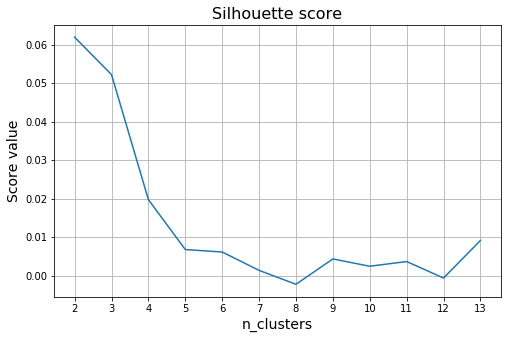

In [698]:
plt.figure(figsize=(8,5))
plt.title('Silhouette score', fontsize=16)
plt.grid()
plt.xticks(ticks=range(0,12), labels=range(2,14))
plt.xlabel('n_clusters', fontsize=14)
plt.ylabel('Score value', fontsize=14)
plt.plot(s_score)
plt.show()

It would seem that from 7 to 12 n_clusters the score is creating a plateu with local minima at 8 and 12. Selecting n_clusters = 8

In [699]:
km = KModes(n_clusters=8, max_iter=100)
clusters_labels = km.fit_predict(X=data)

Each Whiskey is labeled to be located in one of the 7 clusters 

In [700]:
cluster_labels

array([0, 7, 0, 3, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0,
       0, 0, 7, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0,
       3, 3, 0, 0, 0, 4, 0, 0, 0, 3, 3, 0, 0, 6, 3, 0, 0, 3, 0, 3, 0, 0,
       0, 0, 0, 3, 4, 2, 6, 0, 2, 3, 3, 0, 0, 2, 0, 0, 0, 6, 2, 0, 0, 2,
       4, 0, 4, 0, 0, 3, 0, 0, 0, 2, 3, 0, 0, 5, 0, 1, 5, 5, 0, 2, 4],
      dtype=uint16)

Now, let's add the labels to the dataset

In [701]:
data['target'] = cluster_labels

Let's look up the 'Aberlour' to see to which group it belongs, using this grouping I will be able to find similar Whiskeys. As the 'Aberlour' had index 1 in the original <i>df</i> Let's look up what cluster it belongs to.

In [702]:
data['name'] = df['name']
data.loc[data['name']=='Aberlour','target'].iloc[0]

0

So, it is in the cluster 0. Let's see what other similar whiskeys I might like.

In [703]:
data['target'].value_counts()

0    65
3    22
2     7
4     5
7     3
6     3
5     3
1     1
Name: target, dtype: int64

Turns out the 0 is the biggest cluster with 64 other whiskeys. Plenty to choose from.

In [704]:
recommended_whiskey_names = data.loc[data['target']==0, 'name']
print(recommended_whiskey_names)

10           Ben Nevis
51          Glen Keith
88          North Port
3              Ardmore
9                Banff
24            Coleburn
93     Saint Magdalene
104          Tobermory
36         Glen  Albyn
25          Convalmore
39           Glencadam
32            Deanston
0            Aberfeldy
7            Balmenach
73           Kinclaith
11            Benriach
65            Glenugie
54           Glenlochy
82            Lochside
103          Teaninich
96            Speyburn
22              Cardhu
27       Craigellachie
75            Knockdhu
62           Glen Spey
21         Caperdonich
49           Glengoyne
28           Dailuaine
13           Benromach
69           Inchgower
            ...       
85            Millburn
74           Knockando
86          Miltonduff
68            Imperial
94               Scapa
102         Tamnavulin
108       Tullibardine
31          Dalwhinnie
48       Glenglassaugh
55          Glenlossie
107            Tormore
50          Glen Grant
17         

# Feature importances <a id='feat_imp'></a>
[top](#top)

In [721]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

As a way to understand which features determine a whiskey belong to certain category I will create simple non-linear classification model that support feature importances. 

Let's obtain x and y

In [710]:
y = data['target']
y.shape

(109,)

Selecting all the columns without the name

In [716]:
x = df.iloc[:,1:]
x.shape

(109, 81)

In [729]:
def split_into_train_test(x, y, val_size):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_size)
    return x_train, y_train, x_val, y_val

In [730]:
x_train, y_train, x_val, y_val = split_into_train_test(x, y, 0.15)

Scalling 

In [731]:
columns_to_transform = ['age', 'score', '%', 'dist']
scalers = {}
for col in columns_to_transform:
    scaler = MinMaxScaler(feature_range=(0, 1))
    new_column = scaler.fit_transform(X=np.array(x_train[col]).reshape(-1,1))
    new_column_val = scaler.transform(X=np.array(x_val[col]).reshape(-1,1))
    scalers[col] = scaler
    x_train[col] = new_column
    x_val[col] = new_column_val

C:\Users\LaptopM\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\LaptopM\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\LaptopM\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

Transform to make the numerical scaled values more normal

In [736]:
from sklearn.preprocessing import PowerTransformer

In [738]:
def apply_transform(x_tr, x_va, cols_to_trans):
    """
    This function applies the Yeo Johnson tranform to make the data distribution
    more normal
    """
    lambdas_dict = {}
    for col in cols_to_trans:
        pt = PowerTransformer(method='yeo-johnson')
        x_tr[col] = pt.fit_transform(x_tr[col].values.reshape(-1,1))
        x_va[col] = pt.transform(x_va[col].values.reshape(-1,1))
        lambdas_dict[col] = pt.lambdas_
    return x_tr, x_va, lambdas_dict

In [740]:
x_train, x_val, labdas = apply_transform(x_train, x_val, columns_to_transform)

C:\Users\LaptopM\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\LaptopM\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\LaptopM\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Training the model, the model should be optimized with cross-validation over the x_train and y_train and then a score should be obtained from predicting on x_val. However for this particular task it is not necessary.

In [742]:
rfc = RandomForestClassifier(n_estimators=100)

In [744]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

Obtaining feauture importances

In [754]:
features_importances = pd.DataFrame({'Importance': rfc.feature_importances_,
                                    'Feature name': x_train.columns})
features_importances.sort_values(by='Importance', ascending=False, inplace=True)

Plotting the importances

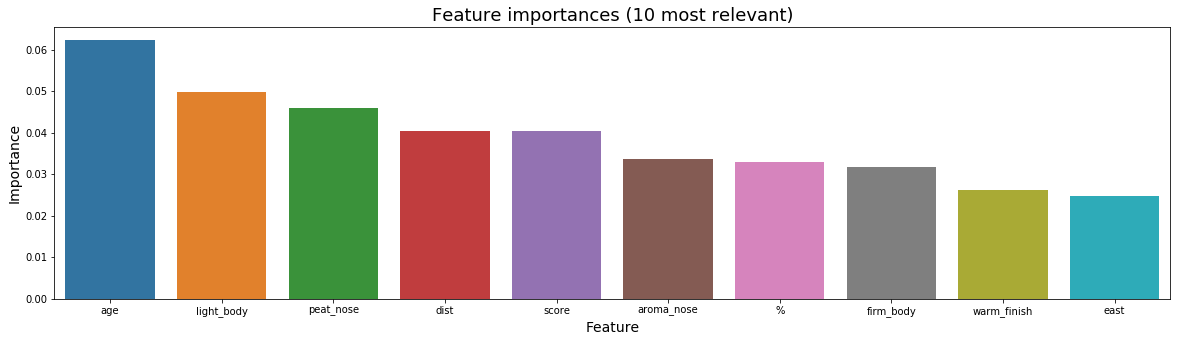

In [761]:
plt.figure(figsize=(20,5))
plt.title('Feature importances (10 most relevant)', fontsize=18)
sns.barplot(data=features_importances.iloc[:10], x='Feature name', y='Importance')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.show()

# Conclusions <a id='conclusions'></a>
[top](#top)

<p> It was determined that a reasonable number of clusters is 8 to categorize the whiskeys. Majority of the whiskeys belonged to the category of the selected whiskey. Use of the clustering enabled to propose similar whiskey names to try. </p> 
<p> Use of the random forest classifier enabled to obtain a very quick result in the form of the feature importances. This factor enables to prioritize the importance of the model input features. Among the 83 features 10 most important are plotted.</p><p> Interestingly enough, age was determined to be the most important. Score, number of distillation cycles and alcohol percentage are found to be also imporant. Additionally to that, eastern region could be a good diffentiator. These features does not require testing the liquor and can be read off the bottle which make an interesting conclusion that 5 out of 10 most important differentiations for the groups can be obtained by comparing bottles.</p>
<p> Other 5 features are related to the taste: body, nose and finish - the palate has not been chosen to be important enough. Neither was color. </p>

<p> It should be however noted that importance omits the corelation between the features, the direction of the impact the variable have on the clusters and interpration based purely on the importances is a good starting point but drawing conclusions can become a challenge </p>